# NY Taxi Tip Amount Prediction
 Nidhi Bendre

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

<class 'ModuleNotFoundError'>: No module named 'seaborn'

a machine learning model to predict <b>tip amount</b> using the NYC Green Taxi Trip Records data for February 2020 is built. 
Here is a link to the accompanying [data dictionary](https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf). E
Data Source: https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2020-02.parquet

### Part 1
<b>load the data directly from the URL</b> into a DataFrame.

In [2]:
tripdata_df = pd.read_parquet(path = 'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2020-02.parquet', #provide the URL to the data source
                      engine = 'fastparquet')
tripdata_df.head()

<class 'ImportError'>: Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.

### Part 2 
Previous EDA and data prep steps (more extensive research in the accompanying notebook)

In [3]:
# remove observations with missing values
# ehail_fee column can be dropped as all values are missing
tripdata_df = tripdata_df.drop(columns = ['ehail_fee'])

# for other rows with multiple null values, there were multiple rows with 7 missing values
# as one of those columns is dropped, for the rest, any observations with 6 or more values can be dropped
tripdata_df = tripdata_df[tripdata_df.isnull().sum(axis=1) < 6]

# change the few missing improvement_surcharge values to 0.3 as the data dictionary mentioned this being the value for it
tripdata_df[tripdata_df['improvement_surcharge'].isna()]=0.30

In [4]:
# convert columns to appropriate data types
tripdata_df['store_and_fwd_flag'] = tripdata_df['store_and_fwd_flag'].astype('category')
tripdata_df['passenger_count'] = tripdata_df['passenger_count'].astype('int64')
tripdata_df['VendorID'] = tripdata_df['VendorID'].astype('category')
tripdata_df['RatecodeID'] = tripdata_df['RatecodeID'].astype('category')
tripdata_df['payment_type'] = tripdata_df['payment_type'].astype('category')
tripdata_df['trip_type'] = tripdata_df['trip_type'].astype('category')
tripdata_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 317739 entries, 0 to 317738
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   VendorID               317739 non-null  category
 1   lpep_pickup_datetime   317739 non-null  object  
 2   lpep_dropoff_datetime  317739 non-null  object  
 3   store_and_fwd_flag     317739 non-null  category
 4   RatecodeID             317739 non-null  category
 5   PULocationID           317739 non-null  float64 
 6   DOLocationID           317739 non-null  float64 
 7   passenger_count        317739 non-null  int64   
 8   trip_distance          317739 non-null  float64 
 9   fare_amount            317739 non-null  float64 
 10  extra                  317739 non-null  float64 
 11  mta_tax                317739 non-null  float64 
 12  tip_amount             317739 non-null  float64 
 13  tolls_amount           317739 non-null  float64 
 14  improvement_surcharg

In [5]:
# remove values with vendorID of 6 (should be 1 or 2)
# remove values with rateID of 99 (should be between 1 and 6)
# remove passenger_count of 0 (shouldn't count as a trip if there are no passengers)

for index, row in tripdata_df.iterrows():
    if row['VendorID'] == 6 or row['RatecodeID'] == 99 or row['passenger_count'] == 0:
        tripdata_df = tripdata_df.drop(index)

tripdata_df['VendorID'].value_counts(dropna=False), tripdata_df['RatecodeID'].value_counts(dropna=False), tripdata_df['passenger_count'].value_counts(dropna=False)


(2.0    264962
 1.0     52311
 Name: VendorID, dtype: int64,
 1.0     309087
 5.0       7172
 2.0        620
 4.0        263
 3.0        130
 6.0          1
 99.0         0
 Name: RatecodeID, dtype: int64,
 1    273446
 2     23121
 5      9178
 3      4927
 6      4809
 4      1775
 7         9
 8         8
 Name: passenger_count, dtype: int64)

In [6]:
# check for negative dollar fare amounts
tripdata_df[tripdata_df['fare_amount']<0]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
225,2.0,2020-02-01 00:46:14,2020-02-01 00:48:00,N,1.0,77.0,77.0,1,0.43,-3.5,-0.5,-0.5,0.0,0.0,-0.3,-4.8,3.0,1.0,0.0
683,2.0,2020-02-01 01:32:39,2020-02-01 01:34:32,N,5.0,134.0,134.0,1,0.00,-25.0,0.0,0.0,0.0,0.0,0.0,-25.0,4.0,2.0,0.0
996,2.0,2020-02-01 02:45:38,2020-02-01 02:46:06,N,1.0,7.0,7.0,1,0.11,-2.5,-0.5,-0.5,0.0,0.0,-0.3,-3.8,3.0,1.0,0.0
1043,2.0,2020-02-01 02:42:26,2020-02-01 02:44:45,N,1.0,7.0,7.0,1,0.51,-4.0,-0.5,-0.5,0.0,0.0,-0.3,-5.3,3.0,1.0,0.0
1086,2.0,2020-02-01 02:05:00,2020-02-01 02:08:33,N,1.0,41.0,41.0,1,0.50,-4.5,-0.5,-0.5,0.0,0.0,-0.3,-5.8,3.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316767,2.0,2020-02-29 21:58:31,2020-02-29 21:58:36,N,1.0,56.0,56.0,1,0.17,-2.5,-0.5,-0.5,0.0,0.0,-0.3,-3.8,3.0,1.0,0.0
317135,2.0,2020-02-29 23:00:42,2020-02-29 23:01:56,N,1.0,74.0,74.0,1,0.01,-3.0,-0.5,-0.5,0.0,0.0,-0.3,-4.3,3.0,1.0,0.0
317427,2.0,2020-02-29 23:17:26,2020-02-29 23:26:50,N,1.0,25.0,65.0,1,0.99,-7.5,-0.5,-0.5,0.0,0.0,-0.3,-8.8,3.0,1.0,0.0
317548,2.0,2020-02-29 22:58:34,2020-02-29 22:59:01,N,2.0,74.0,74.0,5,0.00,-52.0,0.0,-0.5,0.0,0.0,-0.3,-52.8,3.0,1.0,0.0


In [7]:
# include rows with only positive total dollar amounts as there are too many rows with negative amounts
tripdata_df = tripdata_df[tripdata_df['fare_amount'] >= 0]

In [8]:
# check for trip distances of 0
tripdata_df[tripdata_df['trip_distance']==0]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
91,1.0,2020-02-01 00:29:37,2020-02-01 00:43:16,N,1.0,91.0,35.0,1,0.0,17.2,0.0,0.5,0.00,0.0,0.3,18.00,1.0,1.0,0.0
174,2.0,2020-02-01 00:52:05,2020-02-01 00:52:12,N,5.0,213.0,213.0,1,0.0,9.0,0.0,0.0,0.00,0.0,0.3,9.30,1.0,2.0,0.0
209,2.0,2020-02-01 00:08:04,2020-02-01 00:34:08,N,5.0,7.0,193.0,2,0.0,8.0,0.0,0.0,0.00,0.0,0.3,8.30,1.0,2.0,0.0
308,2.0,2020-02-01 00:50:04,2020-02-01 00:50:50,N,5.0,264.0,264.0,1,0.0,13.8,0.0,0.0,2.82,0.0,0.3,16.92,1.0,2.0,0.0
453,1.0,2020-02-01 00:31:26,2020-02-01 00:31:41,N,1.0,129.0,129.0,1,0.0,2.5,0.5,0.5,10.00,0.0,0.3,13.80,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317592,2.0,2020-02-29 23:14:05,2020-02-29 23:16:07,N,5.0,210.0,210.0,4,0.0,60.0,0.0,0.0,12.06,0.0,0.3,72.36,1.0,2.0,0.0
317605,2.0,2020-02-29 23:50:11,2020-02-29 23:50:14,N,5.0,83.0,264.0,1,0.0,8.0,0.0,0.0,1.66,0.0,0.3,9.96,1.0,2.0,0.0
317624,1.0,2020-02-29 23:31:46,2020-02-29 23:57:43,N,1.0,7.0,25.0,1,0.0,24.2,0.0,0.5,0.00,0.0,0.3,25.00,1.0,1.0,0.0
317714,1.0,2020-02-29 23:23:36,2020-02-29 23:40:15,N,1.0,185.0,159.0,1,0.0,22.2,0.0,0.5,0.00,0.0,0.3,23.00,1.0,1.0,0.0


In [9]:
# include rows with only more than 0 trip distance as there are too many rows with a distance of 0
# by doing this, it filters out lower quartile of trips so that it doesn't skew the result to show that taxis are only
# taken for short trips
tripdata_df = tripdata_df[tripdata_df['trip_distance'] > 0]

Text(0.5, 1.0, 'frequency of trip distances')

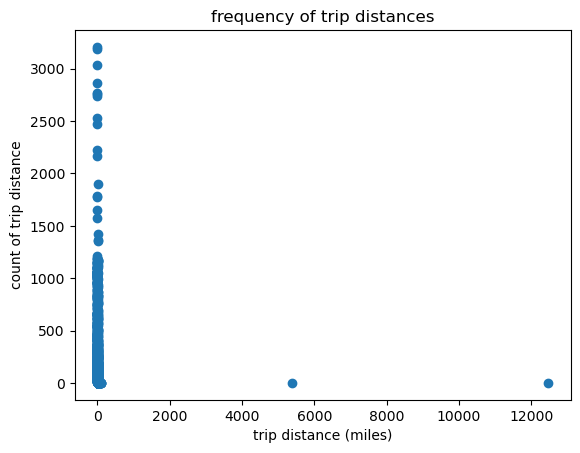

In [10]:
# plot distances and the number of times the distances occur in the dataset to identify outliers
plt.scatter(tripdata_df['trip_distance'].unique(), tripdata_df['trip_distance'].value_counts())
plt.xlabel('trip distance (miles)')
plt.ylabel('count of trip distance')
plt.title('frequency of trip distances')

Text(0.5, 1.0, 'new frequency of trip distances')

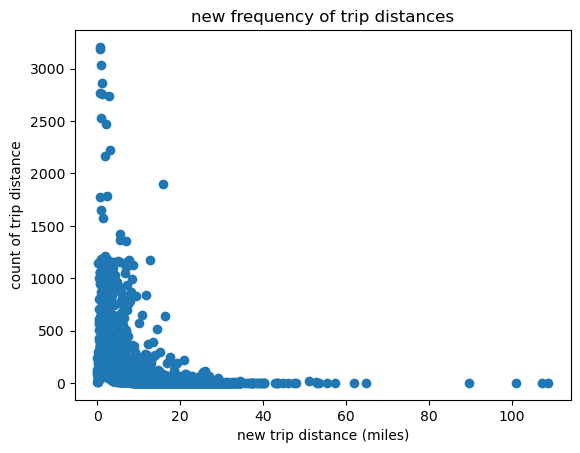

In [11]:
#From above, we can see that there are 2 outliers where distances are greather than 2000 miles. 
#These rows can be dropped
tripdata_df = tripdata_df[tripdata_df['trip_distance'] < 2000]
plt.scatter(tripdata_df['trip_distance'].unique(), tripdata_df['trip_distance'].value_counts())
plt.xlabel('new trip distance (miles)')
plt.ylabel('count of trip distance')
plt.title('new frequency of trip distances')

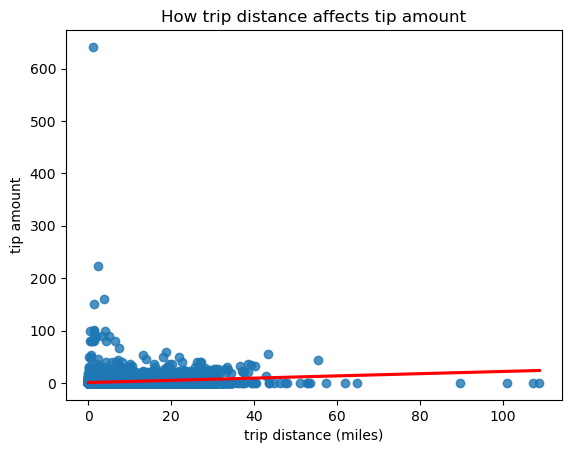

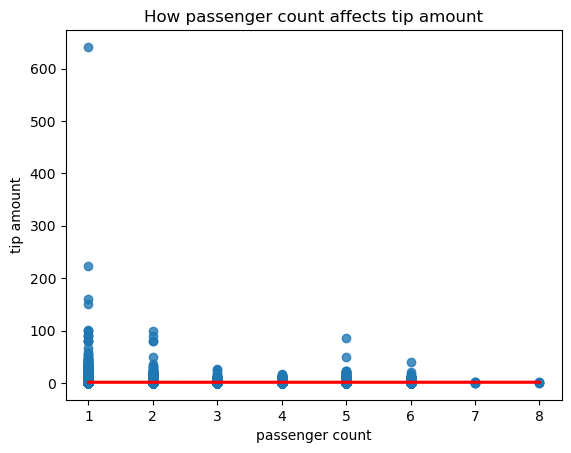

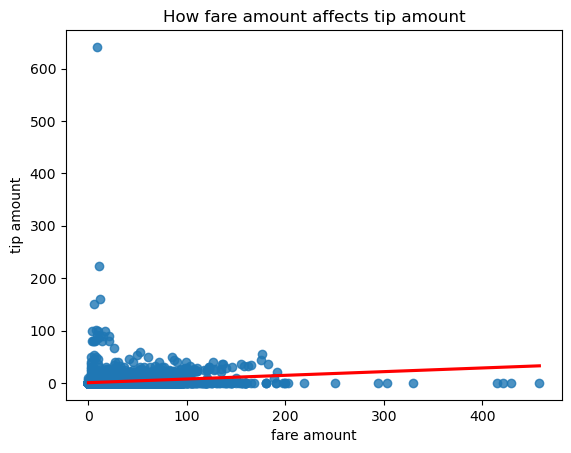

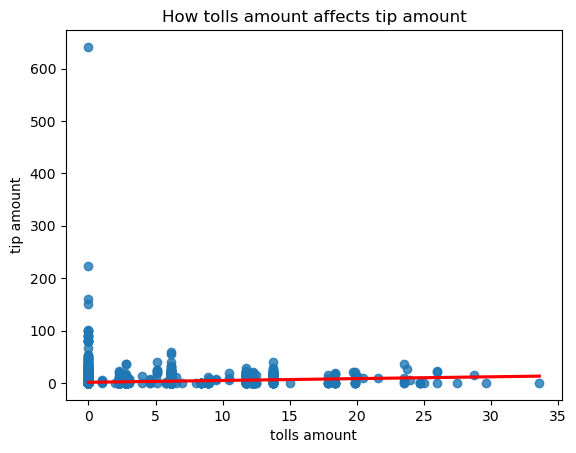

In [12]:
# plot tip amount against a few of the columms to see how it is affected
sns.regplot(data=tripdata_df, x='trip_distance', y='tip_amount', line_kws=dict(color="r"))
plt.xlabel('trip distance (miles)')
plt.ylabel('tip amount')
plt.title('How trip distance affects tip amount')
plt.show()

sns.regplot(data=tripdata_df, x='passenger_count', y='tip_amount', line_kws=dict(color="r"))
plt.xlabel('passenger count')
plt.ylabel('tip amount')
plt.title('How passenger count affects tip amount')
plt.show()

sns.regplot(data=tripdata_df, x='fare_amount', y='tip_amount', line_kws=dict(color="r"))
plt.xlabel('fare amount')
plt.ylabel('tip amount')
plt.title('How fare amount affects tip amount')
plt.show()

sns.regplot(data=tripdata_df, x='tolls_amount', y='tip_amount', line_kws=dict(color="r"))
plt.xlabel('tolls amount')
plt.ylabel('tip amount')
plt.title('How tolls amount affects tip amount')
plt.show()

### Part 3 
Select the required features to build your model.

Based on the scatter plots created earlier, we can see that there is a slight positive correlation between distance, fare amount, toll amount and tip amount while passenger count seems to have no effect on tip amount. The correlations can be further assessed by doing a correlation matrix against tip_amount. 

In [13]:
#encode the categorical features 
categorical_columns = ['VendorID', 'RatecodeID', 'store_and_fwd_flag', 'payment_type', 'trip_type']
tripdata_df = pd.get_dummies(tripdata_df, columns=categorical_columns, drop_first=True)
tripdata_df  

,lpep_pickup_datetime,lpep_dropoff_datetime,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,...,RatecodeID_4.0,RatecodeID_5.0,RatecodeID_6.0,RatecodeID_99.0,store_and_fwd_flag_Y,payment_type_2.0,payment_type_3.0,payment_type_4.0,payment_type_5.0,trip_type_2.0
0,2020-02-01 00:10:25,2020-02-01 00:14:34,74.0,41.0,1,0.76,4.5,0.5,0.5,0.00,...,0,0,0,0,0,1,0,0,0,0
1,2020-02-01 00:16:59,2020-02-01 00:21:35,74.0,74.0,1,0.72,5.0,0.5,0.5,0.00,...,0,0,0,0,0,0,0,0,0,0
2,2020-02-01 00:19:31,2020-02-01 00:25:29,223.0,7.0,1,0.89,6.0,0.5,0.5,1.82,...,0,0,0,0,0,0,0,0,0,0
3,2020-02-01 00:43:52,2020-02-01 00:48:58,145.0,145.0,1,1.12,6.0,0.5,0.5,0.00,...,0,0,0,0,0,1,0,0,0,0
4,2020-02-01 00:32:53,2020-02-01 00:35:19,166.0,166.0,1,0.65,4.0,0.5,0.5,1.06,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317734,2020-02-29 23:21:09,2020-02-29 23:48:18,80.0,130.0,1,9.36,30.5,0.5,0.5,6.36,...,0,0,0,0,0,0,0,0,0,0
317735,2020-02-29 23:56:56,2020-03-01 00:01:25,42.0,42.0,1,0.90,8.0,0.0,0.0,0.00,...,0,1,0,0,0,1,0,0,0,1
317736,2020-02-29 22:55:32,2020-02-29 23:07:22,116.0,235.0,1,2.64,10.5,0.5,0.5,0.00,...,0,0,0,0,0,1,0,0,0,0
317737,2020-02-29 23:35:49,2020-02-29 23:37:22,74.0,74.0,1,0.03,3.0,0.5,0.5,0.00,...,0,0,0,0,0,1,0,0,0,0


In [14]:
correlation_matrix = tripdata_df.corr()

# Get the correlation of each feature with 'tip_amount'
tip_amount_correlation = correlation_matrix['tip_amount']
tip_amount_correlation.sort_values()

/var/folders/zr/drwxp7ws4sg7g_cm9_pdlrbm0000gn/T/ipykernel_52371/3826511619.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = tripdata_df.corr()


payment_type_2.0        -0.475996
payment_type_3.0        -0.026323
payment_type_4.0        -0.016147
trip_type_2.0           -0.007547
store_and_fwd_flag_Y    -0.007486
RatecodeID_5.0          -0.004815
payment_type_5.0        -0.003583
RatecodeID_6.0          -0.000958
mta_tax                 -0.000057
passenger_count          0.001670
VendorID_2.0             0.007433
PULocationID             0.024865
improvement_surcharge    0.024925
RatecodeID_4.0           0.049400
RatecodeID_3.0           0.050612
extra                    0.083237
DOLocationID             0.095882
RatecodeID_2.0           0.102315
tolls_amount             0.136473
trip_distance            0.269296
congestion_surcharge     0.276083
fare_amount              0.280240
total_amount             0.491721
tip_amount               1.000000
RatecodeID_99.0               NaN
Name: tip_amount, dtype: float64

From the correlation matrix, we see that there is a <b>negative correlation between payment_type_2.0 (cash), payment_type_3.0 (no charge), payment_type_4.0(dispute), trip_type_2.0(dispatch), store_and_fwd_flag_Y, RatecodeID_5.0(negotiated fare), payment_type_5.0(unknown), RatecodeID_6.0(group ride), mta_tax</b> and tip amount. There is <b>weak to no correlation between columns such as mta_tax, passenger_count, VendorID_2.0(VeriFone Inc.), PULocationID, and improvement_surcharge</b> and tip amount as the values are very close to 0. There is a <b>fairly positive correlation between RatecodeID_2.0(JFK), tolls amount, trip distance, congestion surcharge, fare amount</b> and tip amount (total amount has higher correlation, but it can be disregarded as this total includes the tip_amount in it which will obivously cause it to change based on tip amount).

Based on the matrix, the features that need to be chosen need to have stronger correlation (positive or negative), so the features chosen are <b>payment_type_2.0 (cash), payment_type_3.0 (no charge), payment_type_4.0(dispute), trip distance, and all features making up total_amount except tip_amount (fare_amount, extra, mta_tax, tolls_amount, improvement_surcharge, congestion_surcharge) as it has high correlation</b>. 

### Part 4
Partition the prepared data into train/test sets

In [15]:
# define features and target
features = ['payment_type_2.0', 'payment_type_3.0', 'payment_type_4.0', 'RatecodeID_2.0', 'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge']
X   = tripdata_df[features] 
# different set of X to test model's MSE with all columns
#X = tripdata_df.drop(['tip_amount','lpep_pickup_datetime', 'lpep_dropoff_datetime', 'total_amount'], axis=1)
y   = tripdata_df['tip_amount']        

# partition data
X_train, X_test, y_train, y_test = train_test_split(X,             
                                                    y,            
                                                    test_size=0.3,  #set aside 30% of the data as the test set
                                                    random_state=7 #reproduce the results
                                                   )

### Part 5
Using the Random Forest algorithm, build a machine learning model that predicts the <b>tip amount</b>.<br>

In [16]:
# as tip amount is a continous variable, regression will be performed
# build the regressor, fit it, and predict
rf = RandomForestRegressor(random_state=7)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

### Part 6 
Evaluate the predictions 

In [17]:
# For a regressor, mean square error can be used as a measure as it measures the 
# average squared difference between predicted and actual values
mse = round(mean_squared_error(y_test, y_pred),2)
print('The mse of the model is: {}'.format(mse))

The mse of the model is: 2.9


### Part 7 
Model's prediction capability

The mse of the model is 2.9. A lower mse indicates better model performance, but a 2.9 mse is on the higher side which means that there is room for improvement in the model. I also tested the model's performance with all the columns, which gave a result of 3.54, which is much higher than using the columns I selected so that shows that the features selected are correct in order to optimize the model.

In [18]:
# list to store MSE values
mse_values = []

# Try  different values for n_estimators and build a model for each
for n in [10, 50, 100, 150, 200, 250, 300]:
    rf_tuned = RandomForestRegressor(n_estimators=n, random_state=7)
    rf_tuned.fit(X_train, y_train)
    y_pred = rf_tuned.predict(X_test)
    mse_tuned = round(mean_squared_error(y_test, y_pred),2)
    
    # Append the MSE value to the list
    mse_values.append((n, mse_tuned))

for n, mse in mse_values:
    print('n_estimators=',n, ', Mean Squared Error =', mse)

n_estimators= 10 , Mean Squared Error = 3.02
n_estimators= 50 , Mean Squared Error = 2.92
n_estimators= 100 , Mean Squared Error = 2.9
n_estimators= 150 , Mean Squared Error = 2.9
n_estimators= 200 , Mean Squared Error = 2.89
n_estimators= 250 , Mean Squared Error = 2.91
n_estimators= 300 , Mean Squared Error = 2.92


When n estimators was 200, the model performed the best.

### Part 8
Feature Importance

In [19]:
best_rf_model = RandomForestRegressor(n_estimators=200, random_state=7)
best_rf_model.fit(X_train, y_train)
feature_imp = best_rf_model.feature_importances_

Text(0.5, 1.0, 'Feature Importance of Each Feature')

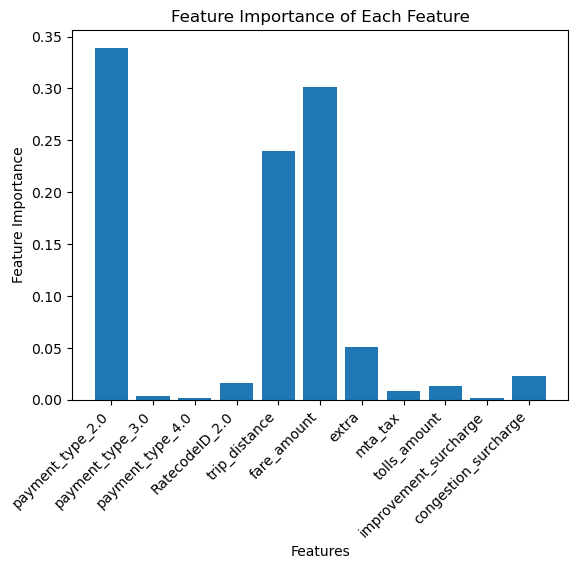

In [20]:
plt.bar(features, feature_imp)
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right') 
plt.ylabel('Feature Importance')
plt.title('Feature Importance of Each Feature')

Based on the above graph, the features that played the biggest role in predicting tip amounts in this model included payment type 2 (cash), fare amount, and trip distance. This means that passengers payment method, how far they went, and the fare had an impact on how much they tipped. 